# Fabled Lands Graph Generator

Creates a visual map of connections between sections in the Fabled Lands series. Each book is represented as a colored cluster, cross-book links are drawn in a distinct color.

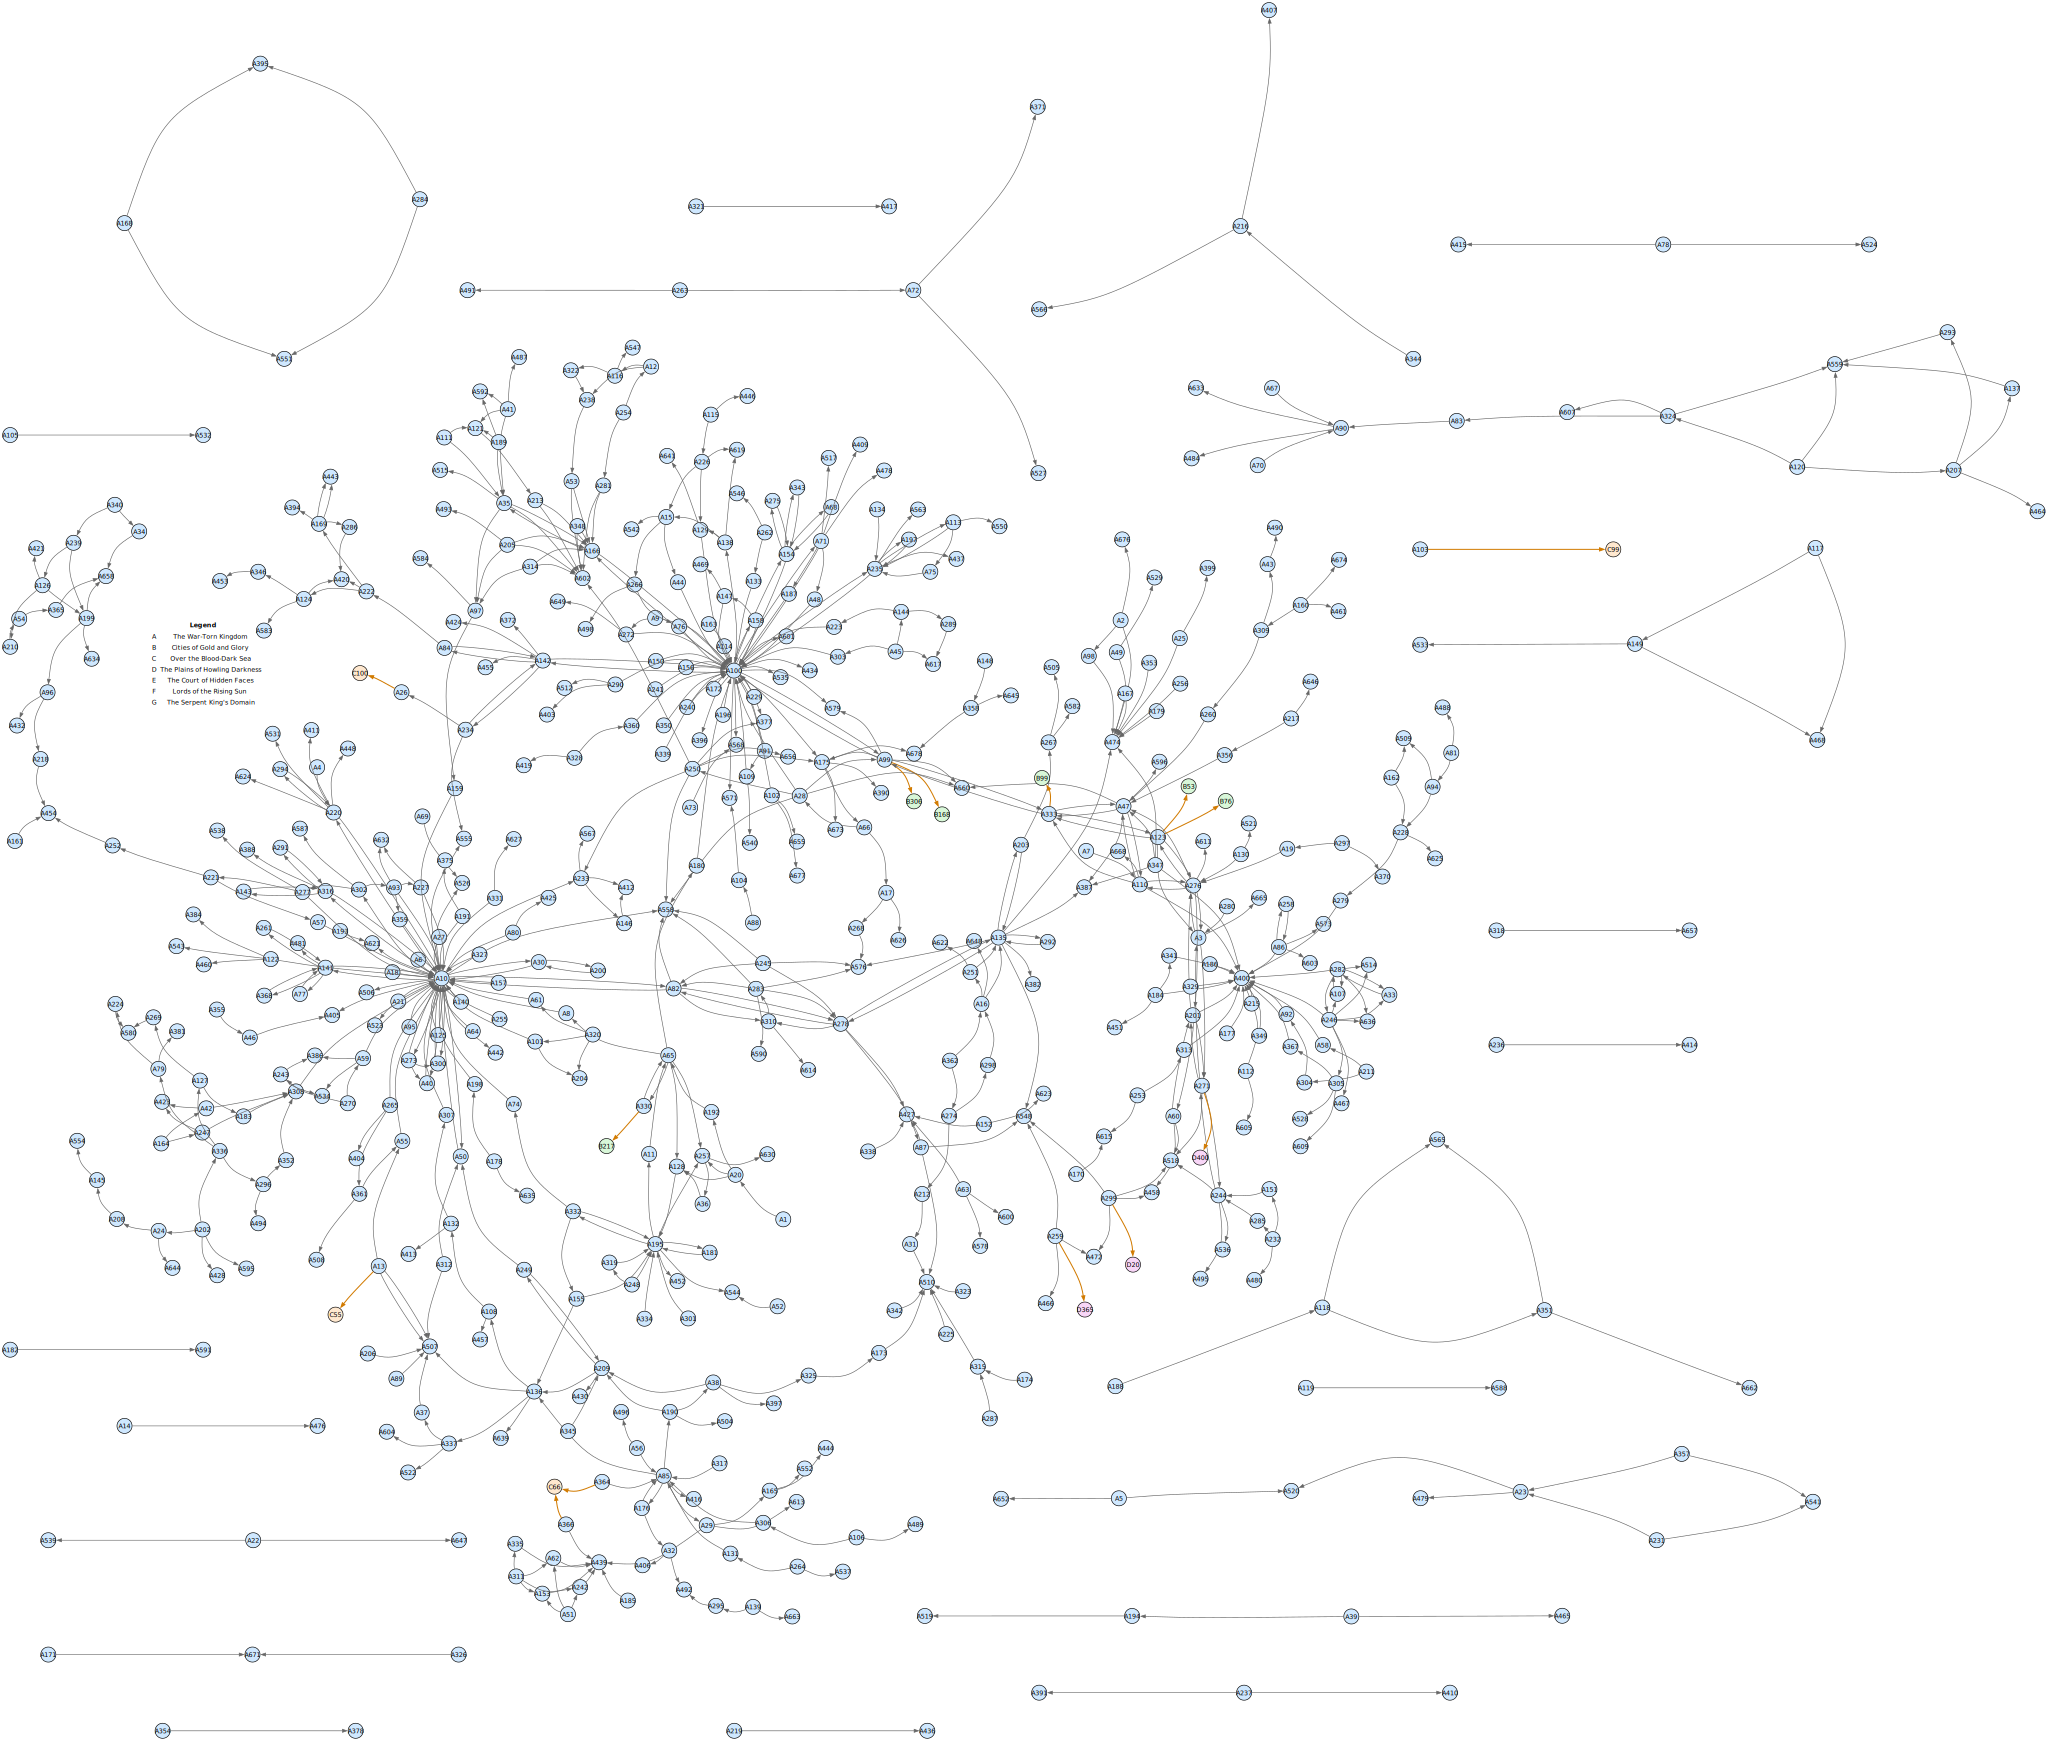

Saved as: fabled_lands_map.pdf


In [1]:
# !pip install graphviz

import os
import glob
import pandas as pd
from graphviz import Digraph
from IPython.display import SVG, display

# Define data path
data_path = "Data"

# Map book letter codes to their full titles
book_names_map = {
    "A": "The War-Torn Kingdom",
    "B": "Cities of Gold and Glory",
    "C": "Over the Blood-Dark Sea",
    "D": "The Plains of Howling Darkness",
    "E": "The Court of Hidden Faces",
    "F": "Lords of the Rising Sun",
    "G": "The Serpent King's Domain",
}

# Load CSV files and build edge list
edges = []
for filepath in glob.glob(os.path.join(data_path, "*.csv")):
    df = pd.read_csv(filepath)
    cols_lower = {c.lower(): c for c in df.columns}
    s_col = cols_lower["source"]
    t_col = cols_lower["target"]
    for a, b in zip(df[s_col], df[t_col]):
        if pd.isna(a) or pd.isna(b):
            continue
        edges.append((str(a).strip().lower(), str(b).strip().lower()))

# Create node set and extract book identifiers
nodes = {u for e in edges for u in e}
books = sorted({n[0] for n in nodes})

# Define color palette
palette = ["#cfe8ff",
           "#d8f7d8",
           "#ffe8cf",
           "#f8d6f7",
           "#f7f7a8",
           "#e0cfe8",
           "#f7bcbc"
          ]
book_fill = {b: palette[i % len(palette)] for i, b in enumerate(books)}
cross_edge_color = "#d17a00"

# Set density, which controls spacing in the layout, between 0 and 1
DENSITY = 0.55

def lerp(a, b, t):
    return a + (b - a) * t

# Compute layout constants by interpolating between two extremes
K                = f"{lerp(1.6, 3.2, DENSITY):.2f}"     # Global spring constant
REPULSE          = f"{lerp(1.2, 2.6, DENSITY):.2f}"     # Node repulsion force
OV_SCALE         = f"{lerp(1.1, 2.2, DENSITY):.2f}"     # Overlap scaling
SEP              = f"+{lerp(0.8, 2.0, DENSITY):.1f}"    # Node separation
ESEP             = f"+{lerp(0.8, 2.0, DENSITY):.1f}"    # Edge separation
EDGE_LEN         = f"{lerp(1.4, 2.4, DENSITY):.1f}"     # Typical edge length
CROSS_EDGE_LEN   = f"{lerp(1.8, 3.2, DENSITY):.1f}"     # Cross-book edges
NODE_WH          = f"{lerp(0.30, 0.36, DENSITY):.2f}"   # Node size

# Initialize graph
g = Digraph("fabled_lands", format="svg", engine="sfdp")

# Set global layout settings
g.attr(splines = "curved",
       overlap = "scale",
       overlap_scaling = OV_SCALE,
       sep = SEP,
       esep = ESEP,
       K = K,
       repulsiveforce = REPULSE,
       maxiter = "16000",
       compound = "true",
       fontname = "Inter"
      )

# Set default node style
g.attr("node",
       shape = "circle",
       style = "filled",
       fontname = "Inter",
       fontsize = "10",
       width = NODE_WH,
       height = NODE_WH,
       fixedsize = "true"
      )

# Set default edge style
g.attr("edge",
       arrowsize = "0.7",
       color = "#666666",
       len = EDGE_LEN
      )

# Create one cluster per book
clusters = {}
for b in books:
    clusters[b] = Digraph(name = f"cluster_{b.upper()}")
    nice_label = book_names_map.get(b.upper(), f"Book {b.upper()}")
    clusters[b].attr(
        label = nice_label,
        style = "rounded, filled",
        color = "#9bb5d7",
        penwidth = "1.2",
        fillcolor = "#eef4ff",
        rank = "same"
    )

# Sorts by book letter, then numerically
def sortkey(n):
    try:
        return (n[0], int(n[1:]))
    except:
        return (n[0], n[1:])

# Add nodes to their corresponding book clusters
for n in sorted(nodes, key = sortkey):
    b = n[0]
    clusters[b].node(n, label = n.upper(), fillcolor = book_fill[b])

# Add clusters
for c in clusters.values():
    g.subgraph(c)

# Add legend
legend_label = (
    '<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0">'
    '<TR><TD COLSPAN="2" BALIGN="CENTER"><B>Legend</B></TD></TR>'
    + "".join(f"<TR><TD>{k}</TD><TD>{v}</TD></TR>" for k, v in book_names_map.items())
    + "</TABLE>>"
)

legend = Digraph(name = "cluster_legend")
legend.attr(
    label = "",
    style = "rounded",
    color = "#9bb5d7",
    penwidth = "1.2",
    fontname = "Inter",
    fontsize = "10",
)

legend.node("legend_table",
            label = legend_label,
            style = "",
            color = "none"
           )
g.subgraph(legend)

# Draw edges
for u, v in edges:
    if u[0] != v[0]:
        g.edge(u, v,
               color = cross_edge_color,
               penwidth = "1.6",
               len = CROSS_EDGE_LEN
              )
    else:
        g.edge(u, v)

# Render and display
svg_data = g.pipe(format="svg").decode("utf-8")
display(SVG(svg_data))

# Export to PDF
pdf_path = g.render(filename="fabled_lands_map",
                    format="pdf",
                    cleanup=True
                   )
print("Saved as:", pdf_path)
